In [25]:
import copy
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sys
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [26]:
class DASTModel():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = '_norm' if is_norm else ''
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_2560.npy')
        feature2 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_1280.npy')
        feature3 = np.load(f'{self.DATA_PATH}/{folder}/{folder}_X{self.norm}_640.npy')
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        

In [27]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
# TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
# TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
# TRAIN_DATASETS = ['Bearing2_1', 'Bearing2_2']
# TEST_DATASET = ['Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7']
TRAIN_DATASETS = ['Bearing3_1', 'Bearing3_2']
TEST_DATASET = ['Bearing3_3']

MODEL_SAVE_NAME = 'Bearing3_pretrain_16'
IS_NORM = False
MODEL_SAVE_PATH = '../../../model'

In [28]:
# selected_indices = [1, 3, 5, 7, 9, 10, 14]
selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 10
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [29]:
dast_model = DASTModel(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME)

In [30]:
dast_model.main(selected_indices)

100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


epoch =  0 train_loss =  0.3249070801668697
rmse_loss =  0.448660671710968 mae_loss =  0.42367565631866455 mse_loss =  0.20129640400409698


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


epoch =  1 train_loss =  0.319348555472162
rmse_loss =  0.228536456823349 mae_loss =  0.12614406645298004 mse_loss =  0.052228908985853195


100%|██████████| 9/9 [00:00<00:00, 12.09it/s]


epoch =  2 train_loss =  0.09538244929475088
rmse_loss =  0.1701335608959198 mae_loss =  0.12068495154380798 mse_loss =  0.028945427387952805


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


epoch =  3 train_loss =  0.08458131862183411
rmse_loss =  0.1537901610136032 mae_loss =  0.13375015556812286 mse_loss =  0.02365141361951828


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


epoch =  4 train_loss =  0.06682369858026505
rmse_loss =  0.11244726926088333 mae_loss =  0.07058680802583694 mse_loss =  0.012644387781620026


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


epoch =  5 train_loss =  0.0373160423607462
rmse_loss =  0.10977012664079666 mae_loss =  0.07698378711938858 mse_loss =  0.012049480341374874


100%|██████████| 9/9 [00:00<00:00, 12.00it/s]


epoch =  6 train_loss =  0.040572656551375985
rmse_loss =  0.10105974227190018 mae_loss =  0.07668795436620712 mse_loss =  0.01021307148039341


100%|██████████| 9/9 [00:00<00:00, 12.34it/s]


epoch =  7 train_loss =  0.033360052646862134
rmse_loss =  0.08496952801942825 mae_loss =  0.05905985087156296 mse_loss =  0.007219820283353329


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


epoch =  8 train_loss =  0.03260440596689781
rmse_loss =  0.082806296646595 mae_loss =  0.05533226579427719 mse_loss =  0.006856882479041815


100%|██████████| 9/9 [00:00<00:00, 11.49it/s]


epoch =  9 train_loss =  0.030271347249961562
rmse_loss =  0.08663180470466614 mae_loss =  0.05473966524004936 mse_loss =  0.007505069021135569


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


epoch =  10 train_loss =  0.027626452191422384
rmse_loss =  0.09691844880580902 mae_loss =  0.06020922213792801 mse_loss =  0.009393185377120972


100%|██████████| 9/9 [00:00<00:00, 13.00it/s]


epoch =  11 train_loss =  0.027065989923559956
rmse_loss =  0.11478637158870697 mae_loss =  0.07104433327913284 mse_loss =  0.013175910338759422


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


epoch =  12 train_loss =  0.025616284201128617
rmse_loss =  0.12778964638710022 mae_loss =  0.0809958204627037 mse_loss =  0.01633019559085369


100%|██████████| 9/9 [00:00<00:00, 12.32it/s]


epoch =  13 train_loss =  0.02480113237268395
rmse_loss =  0.14372281730175018 mae_loss =  0.09357791393995285 mse_loss =  0.020656246691942215


100%|██████████| 9/9 [00:00<00:00, 12.28it/s]


epoch =  14 train_loss =  0.024398307885146804
rmse_loss =  0.1570686399936676 mae_loss =  0.10251922160387039 mse_loss =  0.024670559912919998


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


epoch =  15 train_loss =  0.023522729442144435
rmse_loss =  0.16934631764888763 mae_loss =  0.11280502378940582 mse_loss =  0.028678176924586296


100%|██████████| 9/9 [00:00<00:00, 11.85it/s]


epoch =  16 train_loss =  0.023355535878282454
rmse_loss =  0.18138863146305084 mae_loss =  0.12062916904687881 mse_loss =  0.032901834696531296


100%|██████████| 9/9 [00:00<00:00, 12.29it/s]


epoch =  17 train_loss =  0.02277053993505736
rmse_loss =  0.19125495851039886 mae_loss =  0.12774507701396942 mse_loss =  0.0365784615278244


100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


epoch =  18 train_loss =  0.022256045692807272
rmse_loss =  0.20040421187877655 mae_loss =  0.13664567470550537 mse_loss =  0.040161848068237305


100%|██████████| 9/9 [00:00<00:00, 12.60it/s]


epoch =  19 train_loss =  0.02252919622696936
rmse_loss =  0.20722264051437378 mae_loss =  0.13693399727344513 mse_loss =  0.042941223829984665


100%|██████████| 9/9 [00:00<00:00, 12.52it/s]


epoch =  20 train_loss =  0.021081128882037267
rmse_loss =  0.21392978727817535 mae_loss =  0.14966779947280884 mse_loss =  0.0457659550011158


100%|██████████| 9/9 [00:00<00:00, 12.63it/s]


epoch =  21 train_loss =  0.022151602276911337
rmse_loss =  0.21900808811187744 mae_loss =  0.1447857916355133 mse_loss =  0.04796454310417175


100%|██████████| 9/9 [00:00<00:00, 12.26it/s]


epoch =  22 train_loss =  0.02023088137826158
rmse_loss =  0.22353845834732056 mae_loss =  0.1576893925666809 mse_loss =  0.04996944218873978


100%|██████████| 9/9 [00:00<00:00, 12.34it/s]


epoch =  23 train_loss =  0.021241430956352916
rmse_loss =  0.22548221051692963 mae_loss =  0.15254810452461243 mse_loss =  0.050842225551605225


100%|██████████| 9/9 [00:00<00:00, 12.81it/s]


epoch =  24 train_loss =  0.0201555093517527
rmse_loss =  0.22911682724952698 mae_loss =  0.15921907126903534 mse_loss =  0.05249451845884323


100%|██████████| 9/9 [00:00<00:00, 12.54it/s]


epoch =  25 train_loss =  0.019572475110180676
rmse_loss =  0.2316669374704361 mae_loss =  0.16351841390132904 mse_loss =  0.05366957187652588


100%|██████████| 9/9 [00:00<00:00, 11.79it/s]


epoch =  26 train_loss =  0.01999524390945832
rmse_loss =  0.22985218465328217 mae_loss =  0.15755240619182587 mse_loss =  0.05283202603459358


100%|██████████| 9/9 [00:00<00:00, 13.12it/s]


epoch =  27 train_loss =  0.018579428653336234
rmse_loss =  0.23407165706157684 mae_loss =  0.16928690671920776 mse_loss =  0.05478953942656517


100%|██████████| 9/9 [00:00<00:00, 11.99it/s]


epoch =  28 train_loss =  0.019066222244873643
rmse_loss =  0.23280030488967896 mae_loss =  0.16010484099388123 mse_loss =  0.054195985198020935


100%|██████████| 9/9 [00:00<00:00, 12.99it/s]


epoch =  29 train_loss =  0.01756473700515926
rmse_loss =  0.22583995759487152 mae_loss =  0.16688261926174164 mse_loss =  0.05100368335843086


100%|██████████| 9/9 [00:00<00:00, 12.35it/s]


epoch =  30 train_loss =  0.01892741854923467
rmse_loss =  0.23924501240253448 mae_loss =  0.16510118544101715 mse_loss =  0.057238172739744186


100%|██████████| 9/9 [00:00<00:00, 12.94it/s]


epoch =  31 train_loss =  0.016446138615719974
rmse_loss =  0.23961681127548218 mae_loss =  0.17896297574043274 mse_loss =  0.057416219264268875


100%|██████████| 9/9 [00:00<00:00, 12.99it/s]


epoch =  32 train_loss =  0.018016010807413194
rmse_loss =  0.1993839293718338 mae_loss =  0.13380351662635803 mse_loss =  0.039753951132297516


100%|██████████| 9/9 [00:00<00:00, 12.96it/s]


epoch =  33 train_loss =  0.01588621461350057
rmse_loss =  0.24456481635570526 mae_loss =  0.19584454596042633 mse_loss =  0.059811949729919434


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


epoch =  34 train_loss =  0.02393879249898924
rmse_loss =  0.19441309571266174 mae_loss =  0.11460130661725998 mse_loss =  0.03779644891619682


100%|██████████| 9/9 [00:00<00:00, 12.60it/s]


epoch =  35 train_loss =  0.022097600158303976
rmse_loss =  0.22885504364967346 mae_loss =  0.20453445613384247 mse_loss =  0.05237463116645813


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


epoch =  36 train_loss =  0.03055683212975661
rmse_loss =  0.20050273835659027 mae_loss =  0.1286192089319229 mse_loss =  0.040201351046562195


100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


epoch =  37 train_loss =  0.01522606660404967
rmse_loss =  0.20617567002773285 mae_loss =  0.183998703956604 mse_loss =  0.042508404701948166


100%|██████████| 9/9 [00:00<00:00, 12.21it/s]


epoch =  38 train_loss =  0.021048119459818635
rmse_loss =  0.11090045422315598 mae_loss =  0.07644334435462952 mse_loss =  0.01229891087859869


100%|██████████| 9/9 [00:00<00:00, 12.33it/s]


epoch =  39 train_loss =  0.01818509697396722
rmse_loss =  0.20417606830596924 mae_loss =  0.14321483671665192 mse_loss =  0.041687868535518646


100%|██████████| 9/9 [00:00<00:00, 12.39it/s]


epoch =  40 train_loss =  0.016134230911524758
rmse_loss =  0.21220393478870392 mae_loss =  0.17659296095371246 mse_loss =  0.04503050819039345


100%|██████████| 9/9 [00:00<00:00, 11.79it/s]


epoch =  41 train_loss =  0.03253483777451846
rmse_loss =  0.14264336228370667 mae_loss =  0.08190711587667465 mse_loss =  0.020347129553556442


100%|██████████| 9/9 [00:00<00:00, 12.42it/s]


epoch =  42 train_loss =  0.026274651263116136
rmse_loss =  0.22083766758441925 mae_loss =  0.19965381920337677 mse_loss =  0.0487692765891552


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


epoch =  43 train_loss =  0.032761854818090796
rmse_loss =  0.07992237061262131 mae_loss =  0.054538290947675705 mse_loss =  0.006387584842741489


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


epoch =  44 train_loss =  0.01841321374134471
rmse_loss =  0.14545899629592896 mae_loss =  0.1342923939228058 mse_loss =  0.02115832082927227


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


epoch =  45 train_loss =  0.03094983857590705
rmse_loss =  0.17486689984798431 mae_loss =  0.1480598896741867 mse_loss =  0.030578434467315674


100%|██████████| 9/9 [00:00<00:00, 12.75it/s]


epoch =  46 train_loss =  0.025806936745842297
rmse_loss =  0.07883531600236893 mae_loss =  0.05786128342151642 mse_loss =  0.0062150065787136555


100%|██████████| 9/9 [00:00<00:00, 12.64it/s]


epoch =  47 train_loss =  0.014119014131008752
rmse_loss =  0.19584587216377258 mae_loss =  0.17732232809066772 mse_loss =  0.03835560753941536


100%|██████████| 9/9 [00:00<00:00, 13.54it/s]


epoch =  48 train_loss =  0.027249230796264276
rmse_loss =  0.13054382801055908 mae_loss =  0.08576186001300812 mse_loss =  0.01704169251024723


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


epoch =  49 train_loss =  0.01814692594214446
rmse_loss =  0.1112401932477951 mae_loss =  0.08883266150951385 mse_loss =  0.012374380603432655


100%|██████████| 9/9 [00:00<00:00, 13.79it/s]


epoch =  50 train_loss =  0.014500629713034464
rmse_loss =  0.21855127811431885 mae_loss =  0.20280545949935913 mse_loss =  0.04776465892791748


100%|██████████| 9/9 [00:00<00:00, 14.08it/s]


epoch =  51 train_loss =  0.022875893059083156
rmse_loss =  0.08093290030956268 mae_loss =  0.05508112162351608 mse_loss =  0.006550134625285864


100%|██████████| 9/9 [00:00<00:00, 13.76it/s]


epoch =  52 train_loss =  0.014872161645649208
rmse_loss =  0.12410180270671844 mae_loss =  0.10583812743425369 mse_loss =  0.015401257202029228


100%|██████████| 9/9 [00:00<00:00, 13.01it/s]


epoch =  53 train_loss =  0.01441828852208952
rmse_loss =  0.17918118834495544 mae_loss =  0.15073974430561066 mse_loss =  0.03210590034723282


100%|██████████| 9/9 [00:00<00:00, 13.45it/s]


epoch =  54 train_loss =  0.01575449424692326
rmse_loss =  0.1542624682188034 mae_loss =  0.11255448311567307 mse_loss =  0.02379690855741501


100%|██████████| 9/9 [00:00<00:00, 13.50it/s]


epoch =  55 train_loss =  0.01166570983413193
rmse_loss =  0.16201764345169067 mae_loss =  0.14111271500587463 mse_loss =  0.02624971605837345


100%|██████████| 9/9 [00:00<00:00, 13.50it/s]


epoch =  56 train_loss =  0.013089375040079985
rmse_loss =  0.1642497330904007 mae_loss =  0.13677217066287994 mse_loss =  0.02697797492146492


100%|██████████| 9/9 [00:00<00:00, 15.80it/s]


epoch =  57 train_loss =  0.013864275514303396
rmse_loss =  0.1432390660047531 mae_loss =  0.10840707272291183 mse_loss =  0.02051742933690548


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


epoch =  58 train_loss =  0.010722755195779933
rmse_loss =  0.16332098841667175 mae_loss =  0.14353856444358826 mse_loss =  0.02667374350130558


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


epoch =  59 train_loss =  0.012611642195325758
rmse_loss =  0.16393600404262543 mae_loss =  0.13667625188827515 mse_loss =  0.02687501162290573


100%|██████████| 9/9 [00:00<00:00, 15.80it/s]


epoch =  60 train_loss =  0.01274900154546938
rmse_loss =  0.14570508897304535 mae_loss =  0.1163170114159584 mse_loss =  0.021229971200227737


100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


epoch =  61 train_loss =  0.01025910890247259
rmse_loss =  0.17216308414936066 mae_loss =  0.15326333045959473 mse_loss =  0.02964012511074543


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


epoch =  62 train_loss =  0.012249652205759453
rmse_loss =  0.15557029843330383 mae_loss =  0.12397316843271255 mse_loss =  0.024202119559049606


100%|██████████| 9/9 [00:00<00:00, 15.79it/s]


epoch =  63 train_loss =  0.011534863772491613
rmse_loss =  0.1466119885444641 mae_loss =  0.12227363139390945 mse_loss =  0.021495074033737183


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


epoch =  64 train_loss =  0.010411749839679234
rmse_loss =  0.17762993276119232 mae_loss =  0.15846514701843262 mse_loss =  0.03155239298939705


100%|██████████| 9/9 [00:00<00:00, 15.79it/s]


epoch =  65 train_loss =  0.012290766533826374
rmse_loss =  0.1408764123916626 mae_loss =  0.10491832345724106 mse_loss =  0.01984616555273533


100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


epoch =  66 train_loss =  0.010111506446264684
rmse_loss =  0.16446489095687866 mae_loss =  0.14352251589298248 mse_loss =  0.02704869955778122


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


epoch =  67 train_loss =  0.01106344947280983
rmse_loss =  0.18115723133087158 mae_loss =  0.16090041399002075 mse_loss =  0.032817941159009933


100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


epoch =  68 train_loss =  0.012878281452382604
rmse_loss =  0.1288822740316391 mae_loss =  0.09162190556526184 mse_loss =  0.016610639169812202


100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


epoch =  69 train_loss =  0.009853903689266494
rmse_loss =  0.2014705389738083 mae_loss =  0.18273499608039856 mse_loss =  0.040590379387140274


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


epoch =  70 train_loss =  0.011971097387787368
rmse_loss =  0.15142327547073364 mae_loss =  0.11939403414726257 mse_loss =  0.022929007187485695


100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


epoch =  71 train_loss =  0.011812821910199191
rmse_loss =  0.15214364230632782 mae_loss =  0.12801185250282288 mse_loss =  0.023147687315940857


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


epoch =  72 train_loss =  0.011941085388470028
rmse_loss =  0.20511630177497864 mae_loss =  0.18463973701000214 mse_loss =  0.04207269847393036


100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


epoch =  73 train_loss =  0.014772499471695887
rmse_loss =  0.13415993750095367 mae_loss =  0.09346567839384079 mse_loss =  0.017998887225985527


100%|██████████| 9/9 [00:00<00:00, 13.03it/s]


epoch =  74 train_loss =  0.011445149210178189
rmse_loss =  0.22751761972904205 mae_loss =  0.2098308652639389 mse_loss =  0.051764264702796936


100%|██████████| 9/9 [00:00<00:00, 12.77it/s]


epoch =  75 train_loss =  0.016678482003044337
rmse_loss =  0.12885120511054993 mae_loss =  0.08512566983699799 mse_loss =  0.01660263165831566


100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


epoch =  76 train_loss =  0.012094871503197484
rmse_loss =  0.1673886775970459 mae_loss =  0.14101417362689972 mse_loss =  0.028018968179821968


100%|██████████| 9/9 [00:00<00:00, 12.85it/s]


epoch =  77 train_loss =  0.014023198461573985
rmse_loss =  0.2168087214231491 mae_loss =  0.19469568133354187 mse_loss =  0.047006022185087204


100%|██████████| 9/9 [00:00<00:00, 12.52it/s]


epoch =  78 train_loss =  0.01839578105136752
rmse_loss =  0.14252914488315582 mae_loss =  0.0958920568227768 mse_loss =  0.02031455561518669


100%|██████████| 9/9 [00:00<00:00, 14.06it/s]


epoch =  79 train_loss =  0.010369523531860776
rmse_loss =  0.182952418923378 mae_loss =  0.16235612332820892 mse_loss =  0.03347158804535866


100%|██████████| 9/9 [00:00<00:00, 15.74it/s]


epoch =  80 train_loss =  0.013209103231525255
rmse_loss =  0.1625584214925766 mae_loss =  0.1388578563928604 mse_loss =  0.02642524242401123


100%|██████████| 9/9 [00:00<00:00, 15.63it/s]


epoch =  81 train_loss =  0.014394881087355316
rmse_loss =  0.16560213267803192 mae_loss =  0.13447843492031097 mse_loss =  0.02742406725883484


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


epoch =  82 train_loss =  0.011714604178753992
rmse_loss =  0.24257662892341614 mae_loss =  0.22527143359184265 mse_loss =  0.058843422681093216


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


epoch =  83 train_loss =  0.01449231070970806
rmse_loss =  0.10497266799211502 mae_loss =  0.0663614273071289 mse_loss =  0.011019261553883553


100%|██████████| 9/9 [00:00<00:00, 15.67it/s]


epoch =  84 train_loss =  0.012538511802429438
rmse_loss =  0.17283198237419128 mae_loss =  0.14690661430358887 mse_loss =  0.02987089194357395


100%|██████████| 9/9 [00:00<00:00, 15.69it/s]


epoch =  85 train_loss =  0.012702107739945253
rmse_loss =  0.2025832086801529 mae_loss =  0.17580756545066833 mse_loss =  0.041039954870939255


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


epoch =  86 train_loss =  0.01244599343691435
rmse_loss =  0.15815699100494385 mae_loss =  0.11183729767799377 mse_loss =  0.02501363307237625


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


epoch =  87 train_loss =  0.00893073790292773
rmse_loss =  0.18161045014858246 mae_loss =  0.15815477073192596 mse_loss =  0.03298235312104225


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


epoch =  88 train_loss =  0.01196612666050593
rmse_loss =  0.1944069117307663 mae_loss =  0.1681755781173706 mse_loss =  0.037794046103954315


100%|██████████| 9/9 [00:00<00:00, 15.67it/s]


epoch =  89 train_loss =  0.012496623533984853
rmse_loss =  0.15643803775310516 mae_loss =  0.1144963875412941 mse_loss =  0.024472858756780624


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


epoch =  90 train_loss =  0.008770055163444744
rmse_loss =  0.21996867656707764 mae_loss =  0.19850192964076996 mse_loss =  0.04838621988892555


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


epoch =  91 train_loss =  0.01372676756646898
rmse_loss =  0.1779002547264099 mae_loss =  0.14777502417564392 mse_loss =  0.03164850175380707


100%|██████████| 9/9 [00:00<00:00, 14.47it/s]


epoch =  92 train_loss =  0.012878943473980244
rmse_loss =  0.15893271565437317 mae_loss =  0.12346833199262619 mse_loss =  0.025259606540203094


100%|██████████| 9/9 [00:00<00:00, 15.76it/s]


epoch =  93 train_loss =  0.01054320696534382
rmse_loss =  0.26823747158050537 mae_loss =  0.24602682888507843 mse_loss =  0.07195133715867996


100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


epoch =  94 train_loss =  0.02068683342076838
rmse_loss =  0.13663631677627563 mae_loss =  0.10007286071777344 mse_loss =  0.018669484183192253


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


epoch =  95 train_loss =  0.01251732343290415
rmse_loss =  0.196865513920784 mae_loss =  0.16732457280158997 mse_loss =  0.038756031543016434


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


epoch =  96 train_loss =  0.011635754102220138
rmse_loss =  0.2832227349281311 mae_loss =  0.2629522383213043 mse_loss =  0.08021511137485504


100%|██████████| 9/9 [00:00<00:00, 15.65it/s]


epoch =  97 train_loss =  0.012408200703147385
rmse_loss =  0.08266051858663559 mae_loss =  0.05510714650154114 mse_loss =  0.006832760758697987


100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


epoch =  98 train_loss =  0.013417304661642347
rmse_loss =  0.20279201865196228 mae_loss =  0.18015199899673462 mse_loss =  0.041124604642391205


100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


epoch =  99 train_loss =  0.023095944624704618
rmse_loss =  0.22417452931404114 mae_loss =  0.18843132257461548 mse_loss =  0.0502542220056057
train time: 0.6677842, s/epoch
embed1: 20, embed2: 10, lr: 0.001, dec_seq_len: 6


In [31]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

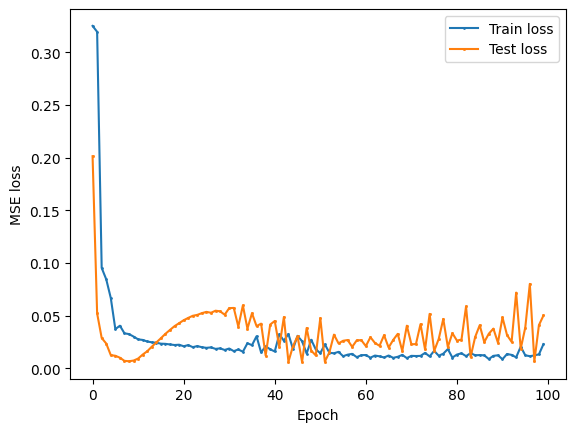

In [32]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

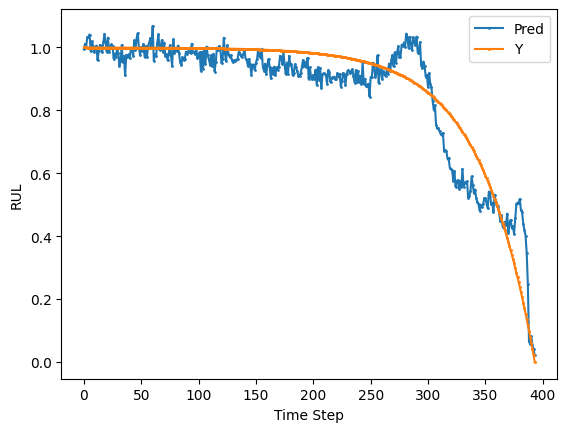

In [33]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

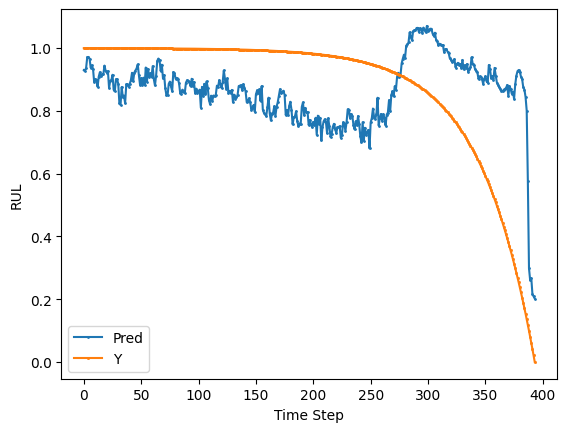

In [34]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [36]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")

0.0087701
0.0062150
0.0788353


In [ ]:
# Run above